In [29]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

**Get Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [30]:
data_dir = "/content/drive/MyDrive/"
train_dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
#print(info)

In [31]:
def drow_bounding_box(image, bbbox, color=(255, 0, 0),thickness=5):
  height = image.shape[0]
  width = image.shape[1]
  y1 = int(height * bbbox[0])
  x1 = int(width * bbbox[1])
  y2 = int(height * bbbox[2])
  x2 = int(width * bbbox[3])
  start_point = (x1, y1)
  end_point = (x2, y2)
  image = cv2.rectangle(image, start_point, end_point, color, thickness)
  plt.imshow(image)
  return None

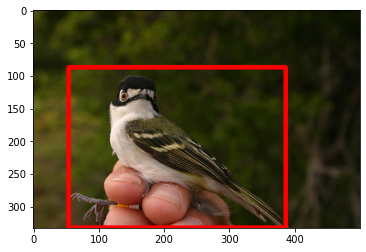

In [32]:
#dict_keys(['bbox', 'image', 'image/filename', 'label', 'label_name', 'segmentation_mask'])
for dat in train_dataset:
  bbbox = dat['bbox'].numpy()
  img = dat['image'].numpy()
  drow_bounding_box(img, bbbox)
  break

**Parameters**

In [38]:
img_height = 224
img_width = 224
shuffle_buffer_size = 1024
btach_size = 64
epochs = 50

**Data Prep**

In [34]:
def preprocess_image(dataset):
  #dic = {}
  image = dataset['image']
  image = tf.cast(image, tf.float32)
  label = dataset['bbox']
  image = tf.image.resize(image, (img_height, img_width,))
  image = image/127.5
  #dic['image'] = image
  #dic['label'] = tf.expand_dims(label, axis=0)
  label = tf.expand_dims(label, axis=0)
  return image, label

In [35]:
def get_training_dataset():
  train_dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
  train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_dataset = train_dataset.shuffle(shuffle_buffer_size)
  train_dataset = train_dataset.batch(btach_size)
  train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
  return train_dataset

**Model**

* Feature Extractor using Transfer Learning
* Dense Layer
* Dense Layer for bounding boxes

In [39]:
#Feature extractor
from tensorflow.keras.applications import MobileNetV2
def feature_extractor(inputs):
  mobilenet = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
  #for layer in mobilenet.layers:
  #  layer.trainable=False
  feature_extractor = mobilenet(inputs)
  return feature_extractor

#Dense Layer
def dense_layers(features):
  x = tf.keras.layers.GlobalAveragePooling2D()(features)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  return x

#bounding box regression
def bounding_box(x):
  bounding_boxes = tf.keras.layers.Dense(4)(x)
  return bounding_boxes

#All together
def model():
  inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
  features = feature_extractor(inputs)
  x = dense_layers(features)
  bounding_boxes = bounding_box(x)
  model = tf.keras.models.Model(inputs=inputs, outputs=bounding_boxes)
  return model
model = model()
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 2052

**Train Model**

In [40]:
training_dataset = get_training_dataset()
history = model.fit(training_dataset, epochs=epochs)

Epoch 1/50
47/47 [==============================] - 25s 394ms/step - loss: 0.1494 - mse: 0.1494
Epoch 2/50
47/47 [==============================] - 22s 402ms/step - loss: 0.0713 - mse: 0.0713
Epoch 3/50
47/47 [==============================] - 22s 404ms/step - loss: 0.0554 - mse: 0.0554
Epoch 4/50
47/47 [==============================] - 22s 399ms/step - loss: 0.0473 - mse: 0.0473
Epoch 5/50
47/47 [==============================] - 22s 398ms/step - loss: 0.0431 - mse: 0.0431
Epoch 6/50
47/47 [==============================] - 22s 401ms/step - loss: 0.0397 - mse: 0.0397
Epoch 7/50
47/47 [==============================] - 22s 402ms/step - loss: 0.0367 - mse: 0.0367
Epoch 8/50
47/47 [==============================] - 22s 403ms/step - loss: 0.0346 - mse: 0.0346
Epoch 9/50
47/47 [==============================] - 22s 399ms/step - loss: 0.0335 - mse: 0.0335
Epoch 10/50
47/47 [==============================] - 22s 399ms/step - loss: 0.0320 - mse: 0.0320
Epoch 11/50
47/47 [====================

**Actual Vs Prediction**

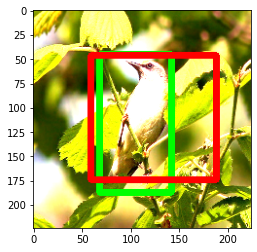

In [50]:
for dat in training_dataset:
  image = dat[0][0].numpy()
  true_bounding_boxes = dat[1][0].numpy()[0]
  drow_bounding_box(image, true_bounding_boxes, (0, 255, 0))
  predicted_bounding_boxes = model.predict(dat[0])[0]
  drow_bounding_box(image, predicted_bounding_boxes, (255, 0, 0))
  break